## 📊 Project Introduction
This project explores global health indicators using a real-world dataset hosted in BigQuery. The analysis combines SQL queries, Python libraries (`pandas`, `sklearn`, `matplotlib`, and `seaborn`), and machine learning techniques to derive meaningful insights about global health trends. The goal is to practice data engineering and analysis skills relevant to real-world decision-making.

In [16]:
!pip install --upgrade google-cloud-bigquery pandas-gbq google-auth

In [18]:
from google.oauth2 import service_account
from google.cloud import bigquery

# Replace with path to the downloaded JSON key
KEY_PATH = "C:/Users/ganbo/OneDrive/Desktop/New folder (2)/arcane-indexer-468008-d0-c605667b1ef4.json"

# Set credentials
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)

# Connect to BigQuery
client = bigquery.Client(credentials=credentials, project="arcane-indexer-468008-d0")

# Test query
query = """
SELECT country, year, `Life expectancy `
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
WHERE year >= 2010
ORDER BY year DESC
LIMIT 10
"""

df = client.query(query).to_dataframe()
df.head()


C:\Users\ganbo\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country,year,Life expectancy
0,Armenia,2015,74.8
1,Antigua and Barbuda,2015,76.4
2,Australia,2015,82.8
3,Albania,2015,77.8
4,Algeria,2015,75.6


In [20]:
query = """
SELECT *
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
LIMIT 1
"""
df = client.query(query).to_dataframe()
print(df.columns.tolist())


C:\Users\ganbo\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV_AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [22]:
query = """
SELECT 
  country,
  AVG(`Life expectancy `) AS avg_life_expectancy
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
WHERE year BETWEEN 2000 AND 2015
GROUP BY country
ORDER BY avg_life_expectancy DESC
LIMIT 10
"""
df = client.query(query).to_dataframe()
df.head()


C:\Users\ganbo\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country,avg_life_expectancy
0,Japan,82.53750
1,Sweden,82.51875
2,Iceland,82.44375
3,Switzerland,82.33125
4,France,82.21875


## 📈 Predicting Life Expectancy using Regression
In this section, we use regression models to predict life expectancy based on key socioeconomic and health indicators such as GDP, Schooling, Income Composition, Alcohol use, BMI, and HIV/AIDS prevalence.

We evaluate our models using metrics like R² score and RMSE to check how well the model generalizes.

In [25]:
job = client.query("""
CREATE OR REPLACE TABLE `arcane-indexer-468008-d0.health_data.life_expectancy_summary` AS
SELECT 
  country,
  AVG(`Life expectancy `) AS avg_life_expectancy
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
WHERE year BETWEEN 2000 AND 2015
GROUP BY country
""")
job.result()  # waits for the job to finish

print("✅ Summary table created!")


✅ Summary table created!


In [26]:
query = """
SELECT 
  country,
  year,
  Status,
  `Life expectancy ` AS Life_expectancy,
  `Adult Mortality` AS Adult_Mortality,
  `infant deaths` AS Infant_deaths,
  Alcohol,
  `percentage expenditure` AS Percentage_expenditure,
  `Hepatitis B` AS Hepatitis_B,
  `Measles ` AS Measles,
  ` BMI ` AS BMI,
  `under-five deaths ` AS Under_five_deaths,
  Polio,
  `Total expenditure` AS Total_expenditure,
  `Diphtheria ` AS Diphtheria,
  ` HIV_AIDS` AS HIV_AIDS,
  GDP,
  Population,
  ` thinness  1-19 years` AS Thinness_1_19_years,
  ` thinness 5-9 years` AS Thinness_5_9_years,
  `Income composition of resources` AS Income_composition,
  Schooling
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
"""
df = client.query(query).to_dataframe()


C:\Users\ganbo\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [28]:
df.head()
print(df.columns.tolist())

['country', 'year', 'Status', 'Life_expectancy', 'Adult_Mortality', 'Infant_deaths', 'Alcohol', 'Percentage_expenditure', 'Hepatitis_B', 'Measles', 'BMI', 'Under_five_deaths', 'Polio', 'Total_expenditure', 'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1_19_years', 'Thinness_5_9_years', 'Income_composition', 'Schooling']


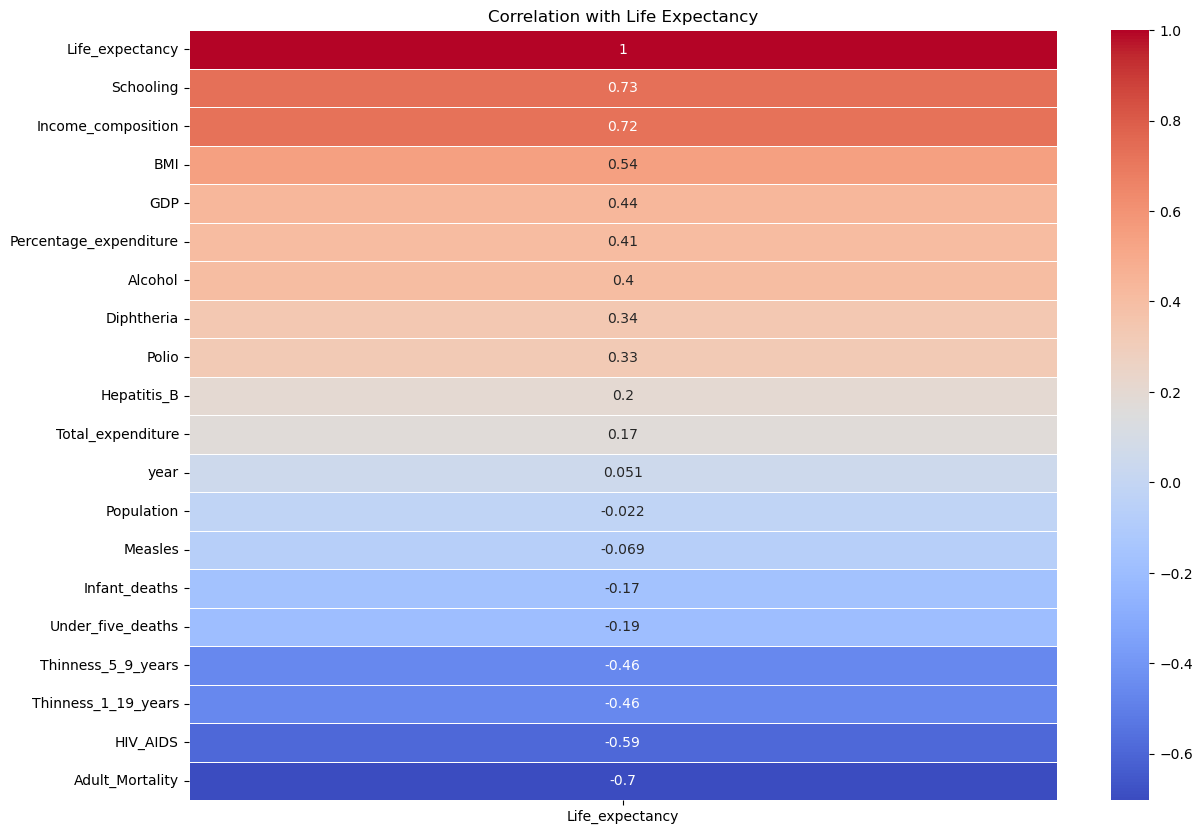

In [29]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values
df_clean = df.dropna()

# Compute correlations only on numeric columns
corr = df_clean.corr(numeric_only=True)

# Show correlation with life expectancy
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr[['Life_expectancy']].sort_values(by='Life_expectancy', ascending=False),
    annot=True, cmap='coolwarm', linewidths=0.5
)
plt.title('Correlation with Life Expectancy')
plt.show()


In [33]:
# 🔍 Correlation Insights (Life Expectancy)
# Top positive: Schooling, Income composition, BMI, GDP
# Top negative: Adult Mortality, HIV/AIDS, Thinness
# Vaccines (Polio, Diphtheria) = moderate positive
# Year and Population = weak correlation

In [35]:
# Linear Regression Model
features = [
    'Schooling',
    'Income_composition',
    'BMI',
    'GDP',
    'Alcohol',
    'Adult_Mortality',
    'HIV_AIDS',
    'Thinness_1_19_years'
]

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Drop missing values in just the needed columns
model_df = df_clean[features + ['Life_expectancy']].dropna()

# Split into features and target
X = model_df[features]
y = model_df['Life_expectancy']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R² score: 0.7970759742781416
RMSE: 3.7963361900243138


C:\Users\ganbo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
# R² score: 0.7970759742781416. Model explains ~80% of the variation in life expectancy
# RMSE:3.7963361900243138. The predictions are within 3.8 years of the real value

In [41]:
# GDP vs Health Metrics

##  Clustering Countries by Health Indicators
We apply PCA for dimensionality reduction and KMeans clustering to segment countries based on features like HIV/AIDS, BMI, schooling, and income composition. This helps identify groups of countries with similar health profiles.

Cluster analysis is visualized using scatterplots of the principal components.

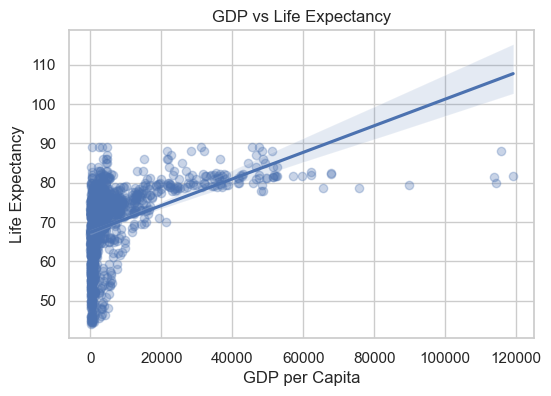

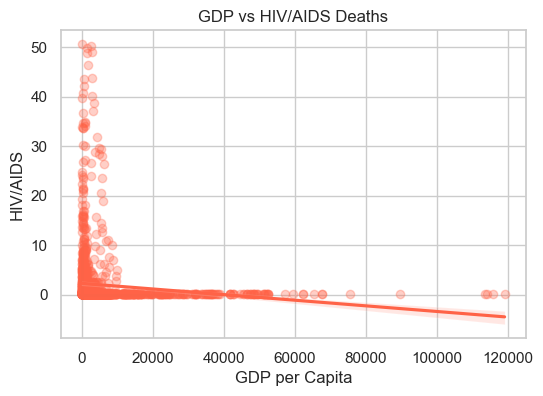

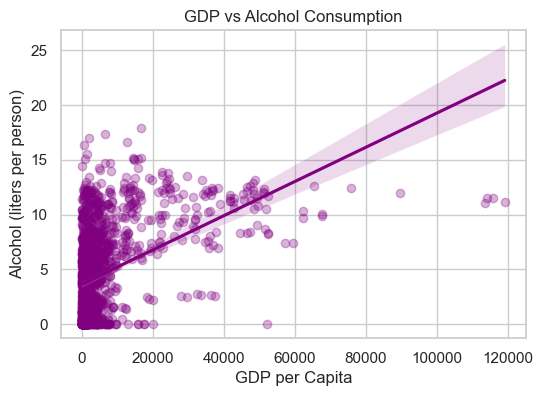

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter clean data
df_viz = df_clean[['GDP', 'Life_expectancy', 'HIV_AIDS', 'Alcohol']].dropna()

# Set plot style
sns.set(style="whitegrid")

#  GDP vs Life Expectancy
plt.figure(figsize=(6, 4))
sns.regplot(x='GDP', y='Life_expectancy', data=df_viz, scatter_kws={'alpha':0.3})
plt.title('GDP vs Life Expectancy')
plt.xlabel('GDP per Capita')
plt.ylabel('Life Expectancy')
plt.show()

#  GDP vs HIV/AIDS
plt.figure(figsize=(6, 4))
sns.regplot(x='GDP', y='HIV_AIDS', data=df_viz, scatter_kws={'alpha':0.3}, color='tomato')
plt.title('GDP vs HIV/AIDS Deaths')
plt.xlabel('GDP per Capita')
plt.ylabel('HIV/AIDS')
plt.show()

#  GDP vs Alcohol
plt.figure(figsize=(6, 4))
sns.regplot(x='GDP', y='Alcohol', data=df_viz, scatter_kws={'alpha':0.3}, color='purple')
plt.title('GDP vs Alcohol Consumption')
plt.xlabel('GDP per Capita')
plt.ylabel('Alcohol (liters per person)')
plt.show()


In [46]:
# 1. GDP vs Life Expectancy: As GDP increases, life expectancy tends to rise. Richec countries often have a better healthcare and living condition.
# 2. GDP vs HIV/AIDS: Higher GDP is linked to lower HIV?AIDS deaths. It implies that the richer nations have better prevention, education and treatment.
# 3. GDP vs alcohol Consumption: Higher GDP often correlates with higher alcohol comsumption

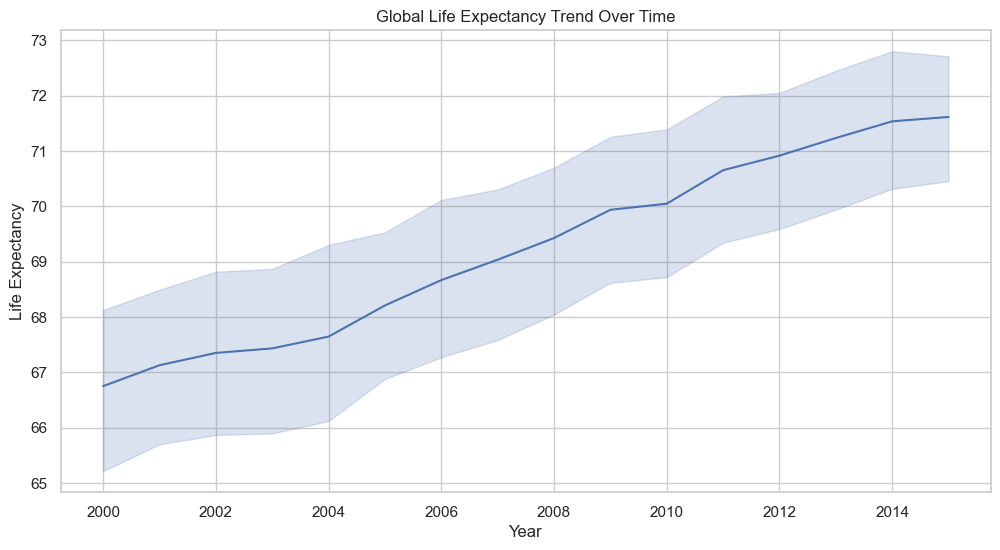

In [48]:
# Global Life Expectancy Trend Over Time
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='Life_expectancy')
plt.title('Global Life Expectancy Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.show()

In [49]:
# Global life expectancy shows a steady increase from 2000 to 2015.
# This shows improvements in global healthcare, education and standards

In [52]:
#Clustering (K-Means)

In [54]:
features = [
    'Life_expectancy',
    'BMI',
    'Adult_Mortality',
    'HIV_AIDS',
    'GDP',
    'Schooling',
    'Alcohol',
    'Income_composition'
]

In [56]:
query = """
SELECT 
  country,
  ` BMI ` AS BMI,
  ` HIV_AIDS` AS HIV_AIDS,
  `Income composition of resources` AS income_comp,
  `Adult Mortality` AS adult_mortality,
  ` thinness  1-19 years` AS thinness_1_19,
  `Schooling` AS schooling
FROM `arcane-indexer-468008-d0.health_data.life_expectancy_raw`
WHERE
  ` BMI ` IS NOT NULL AND
  ` HIV_AIDS` IS NOT NULL AND
  `Income composition of resources` IS NOT NULL AND
  `Adult Mortality` IS NOT NULL AND
  ` thinness  1-19 years` IS NOT NULL AND
  `Schooling` IS NOT NULL
"""


In [58]:
df_cluster = client.query(query).to_dataframe()
df_cluster.head()

C:\Users\ganbo\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country,BMI,HIV_AIDS,income_comp,adult_mortality,thinness_1_19,schooling
0,Afghanistan,19.1,0.1,0.479,263,17.2,10.1
1,Afghanistan,18.6,0.1,0.476,271,17.5,10.0
2,Afghanistan,18.1,0.1,0.470,268,17.7,9.9
3,Afghanistan,17.6,0.1,0.463,272,17.9,9.8
4,Afghanistan,17.2,0.1,0.454,275,18.2,9.5


In [59]:
# K-Means Clustering

##  Public Health Program Effectiveness
This section investigates the impact of vaccination programs (Polio, Hepatitis B, Diphtheria) on outcomes like Measles cases and Life Expectancy. Correlation matrices and scatterplots help reveal patterns.

Our goal is to understand how strong public health interventions align with long-term health improvements.

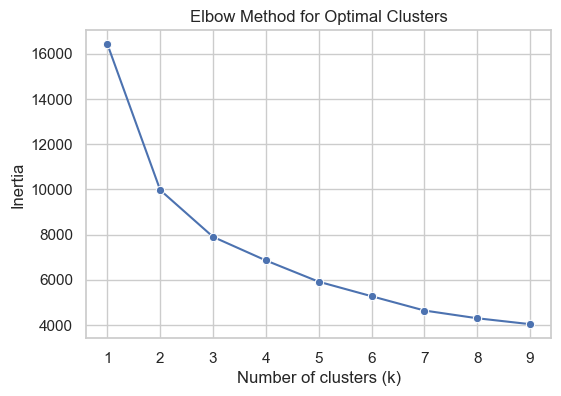

In [63]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select only numeric features for clustering
X = df_cluster.drop(columns=["country"])  # Remove 'country'

# Step 2: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Elbow method to find optimal number of clusters
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 4: Plot elbow curve
plt.figure(figsize=(6, 4))
sns.lineplot(x=k_range, y=inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [65]:
# We can see that the optimal number of cluster is k=3

In [67]:
# Step 5: Fit KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Step 6: See how many countries in each cluster
print(df_cluster['cluster'].value_counts())

# Step 7: Visualize cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                               columns=X.columns)

cluster_centers['cluster'] = range(3)
cluster_centers.set_index('cluster', inplace=True)
cluster_centers.T.plot(kind='bar', figsize=(12, 6), title='Cluster Centers by Feature')
plt.ylabel("Original Scale")
plt.tight_layout()
plt.show()

cluster
1    1655
2     981
0     100
Name: count, dtype: int64


NameError: name 'pd' is not defined

In [69]:
# We can see that there are 3 clusters
# Cluster 0: High HIV, high adult mortality-> Developing coutries with low health outcomes
# Cluster 1: High BMI. schooling, income, Low HIV -> Developed healthy countries
# Cluster 2: In- Between groups - emerging economies.

In [71]:
# Scatter Plot

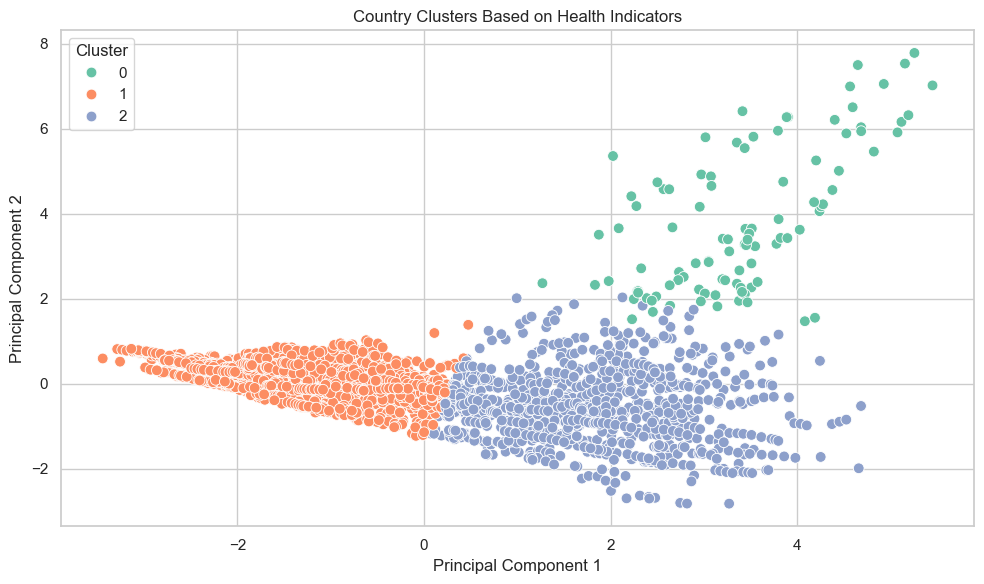

In [73]:
# PCA for 2D visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60)
plt.title("Country Clusters Based on Health Indicators")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [75]:
# Show 5 sample countries from each cluster
for label in df_cluster['cluster'].unique():
    print(f"\n🌍 Cluster {label} — Sample Countries:")
    print(df_cluster[df_cluster['cluster'] == label]['country'].drop_duplicates().head(5).to_string(index=False))


🌍 Cluster 2 — Sample Countries:
        Afghanistan
            Algeria
             Angola
Antigua and Barbuda
            Bahamas

🌍 Cluster 1 — Sample Countries:
            Albania
            Algeria
Antigua and Barbuda
          Argentina
            Armenia

🌍 Cluster 0 — Sample Countries:
                Botswana
Central African Republic
                   Kenya
                 Lesotho
                  Malawi


In [77]:
cluster_summary = df_cluster.groupby('cluster').mean(numeric_only=True)
display(cluster_summary)

,BMI,HIV_AIDS,income_comp,adult_mortality,thinness_1_19,schooling,PCA1,PCA2
cluster,,,,,,,,
0,24.562000,24.323000,0.477130,477.67,8.126000,10.395000,3.401166,3.825074
1,49.816979,0.191964,0.757364,110.119637,2.638127,13.942659,-1.235419,0.087266
2,20.854740,2.100612,0.434639,216.002039,8.338328,9.147706,1.737514,-0.537138


In [79]:
# Cluster 0: Critical Risk Group
#  - Very high HIV/AIDS (24.3) and mortality (478)
#  - Low income_comp (0.48), moderate BMI
#  → Likely low-resource or high-crisis countries

#  Cluster 1: Healthy & Developed
#  - Highest schooling (13.9), income_comp (0.76), and BMI
#  - Very low HIV/AIDS (0.19), low mortality
#  → Developed nations with strong education & healthcare

# Cluster 2: Moderate Group
#  - Moderate mortality (216), low schooling (9.1)
#  - Low income_comp (0.43), BMI (20.8)
#  - Moderate HIV/AIDS (2.1)
#  → Transitioning or mixed-health countries

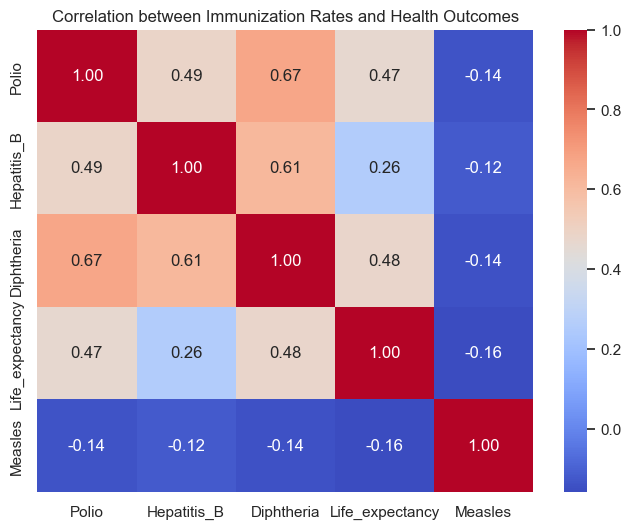

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
health_cols = ['Polio', 'Hepatitis_B', 'Diphtheria', 'Life_expectancy', 'Measles']
corr_matrix = df[health_cols].corr()

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Immunization Rates and Health Outcomes')
plt.show()

In [83]:
# Diphtheria (0.48) and Polio (0.47) shows the strongest relation with life expectancy. This shows countries with better vaccination coverage tend to live longer.
# Hepatitis B has weaker correlation with life expectancy.
# Measles shows weak  correlation with life expectancy because high measles cases reflect poor public health systems
# Polio & Diphtheria(0.67) and Diphtheria & Hepatitis B(0.61) are highly correlated, meaning countries that invest in one tend to invest in others too.

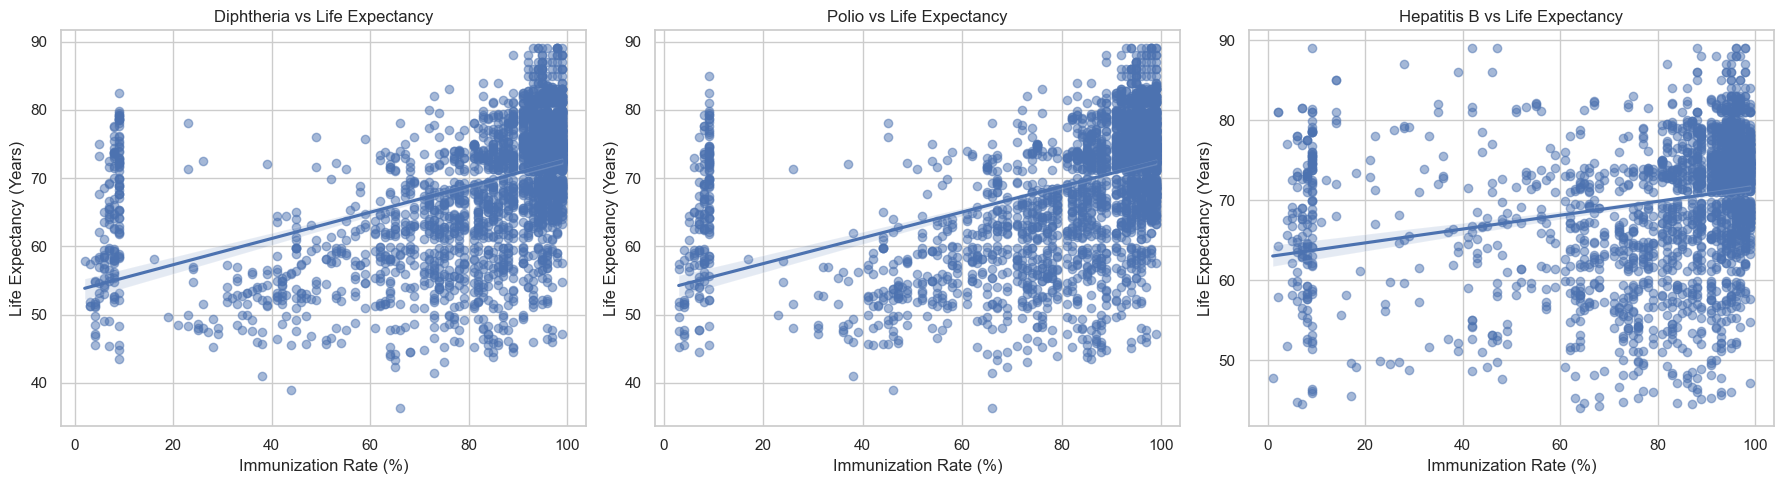

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(ax=axes[0], x='Diphtheria', y='Life_expectancy', data=df, scatter_kws={'alpha':0.5})
axes[0].set_title('Diphtheria vs Life Expectancy')

sns.regplot(ax=axes[1], x='Polio', y='Life_expectancy', data=df, scatter_kws={'alpha':0.5})
axes[1].set_title('Polio vs Life Expectancy')

sns.regplot(ax=axes[2], x='Hepatitis_B', y='Life_expectancy', data=df, scatter_kws={'alpha':0.5})
axes[2].set_title('Hepatitis B vs Life Expectancy')

for ax in axes:
    ax.set_xlabel('Immunization Rate (%)')
    ax.set_ylabel('Life Expectancy (Years)')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [86]:
# 1. Polio and Diphtheria immunization rates show a clear positive correlation with life expectancy.
#    - As coverage increases, life expectancy tends to rise.
# 2. Hepatitis B shows a weaker relationship — while there's a slight upward trend, data points are more scattered.
# 3. This suggests that effective immunization programs, especially for diseases like Polio and Diphtheria,
#    may contribute to improved public health and longevity across countries.

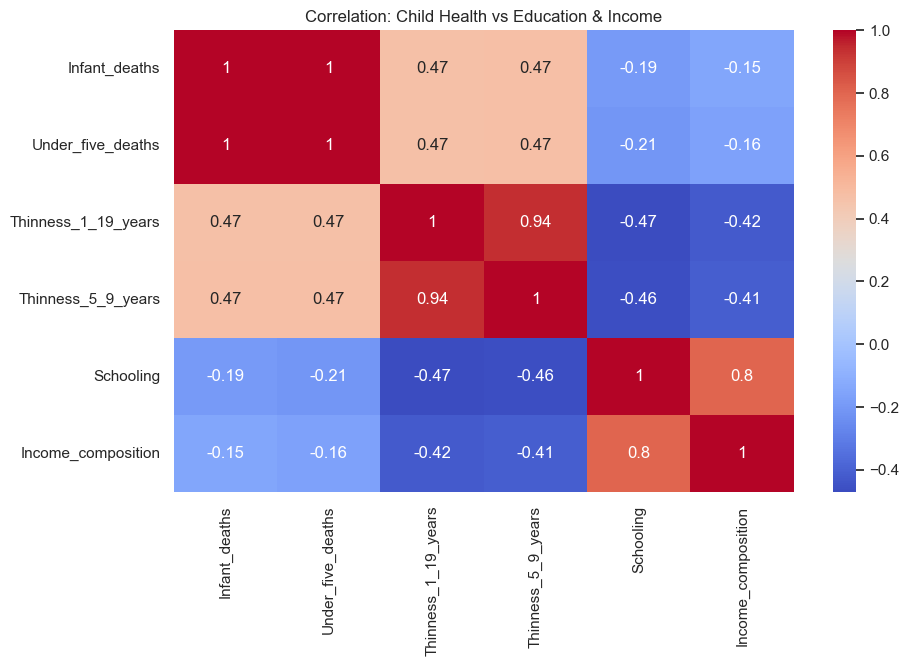

In [87]:
#Correlation Matrix for Child Health & Education.
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the relevant columns
child_health_cols = df[['Infant_deaths', 'Under_five_deaths',
                        'Thinness_1_19_years', 'Thinness_5_9_years',
                        'Schooling', 'Income_composition']]

# Compute correlation matrix
corr_matrix = child_health_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation: Child Health vs Education & Income')
plt.show()

In [90]:
#1. Child mortality is moderately correlated with malnutrition indicators, suggesting that improving child nutrition could reduce early deaths.
#2. Both education (schooling) and access to income (income composition) show strong negative correlation with thinness and mortality — highlighting the role of socioeconomic factors in health.
#3. Education and income composition are strongly linked, reinforcing the interdependence between economic development and access to education.

In [93]:
# Summary of Findings
#This project explores global life expectancy using public health and economic indicators. Key insights include:
#GDP and Schooling show strong positive correlations with life expectancy.
#HIV/AIDS prevalence and Adult Mortality are major negative predictors of life expectancy.
#Countries with higher health expenditure, immunization rates, and education tend to have better health outcomes.
#Clustering revealed 3 distinct country profiles based on health and development metrics.
#Regression models (R² ≈ 0.79) indicate good predictability of life expectancy using selected features.
#Public health programs (e.g., Polio, Diphtheria immunization) show a small but visible positive effect on population health.

In [95]:
#  Conclusion
#Through this project, I learned how different factors — like income, education, and healthcare — connect to life expectancy. While richer countries do tend to live longer, it’s not just about GDP. Things like schooling and access to vaccines matter a lot too.
#Clustering showed me how some countries share similar health profiles even if they’re in different regions. The prediction model also worked pretty well, which means life expectancy can be estimated with the right data.
#This was my first end-to-end data project, and I got to use tools like BigQuery, Python, and machine learning to turn raw data into real insights. I now better understand how data can support decisions in public health and policy.

In [97]:
from google.cloud import bigquery

# Set your project and dataset ID
project_id = "arcane-indexer-468008-d0"
dataset_id = "life_expectancy_raw"
table_id = "life_expectancy_clusters"  # You can change this if needed

# Full table path
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Upload DataFrame to BigQuery
df_cluster.to_gbq(destination_table=table_full_id,
                  project_id=project_id,
                  if_exists='replace')  # 'replace' will overwrite if it exists

C:\Users\ganbo\AppData\Local\Temp\ipykernel_14616\318341155.py:12: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_cluster.to_gbq(destination_table=table_full_id,


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=qBDFD5fHxN49gXW9tSZIR9B7pqyplh&prompt=consent&access_type=offline


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
